## Set-up
### Dependencies
We use `scikit-learn` for implementing models and `sklearn-rvm` for a Relevance Vector Machine (RVM) implementation. SMOTE is performed with the `imbalanced-learn` library. Also used are `numpy` and `pandas` for processing data into nice data frames.
### Constants

In [4]:
import numpy as np

SEED = 24
BIN_COUNT = 512
CV_COUNT = 10
TEST_SIZE = 0.2

np.random.seed(SEED)

### Utility Functions

In [21]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
import json
import pandas as pd


def get_bin_values_from_sketch(fname: str) -> list[int]:
    try:
        json_data = open(
            f"../sketches/sketch_size_512/sample_{fname}.json")
        return json.load(json_data)["signatures"][0]["Sketch"]["mins"]
    except:
        return [-1] * BIN_COUNT


def get_train_test_f1_score(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return f1_score(y_train, clf.predict(X_train)), f1_score(y_test, clf.predict(X_test))


def get_f1_results(clf, X, y):
    metrics = ["Train", "Test", "Mean CV", "Std CV"]

    if len(X) == 0:
        return dict(zip(metrics, ["n/a"] * len(metrics)))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE)
    f1_train, f1_test = get_train_test_f1_score(clf,
                                                X_train, y_train, X_test, y_test)
    X_train, y_train = shuffle(X_train, y_train)
    cv_score = cross_val_score(
        clf, X_train, y_train, scoring="f1", cv=CV_COUNT)
    return dict(zip(metrics, (f1_train, f1_test, cv_score.mean(), cv_score.std())))


def get_classifier_performance(X, y, classifiers, feature_map):
    return pd.DataFrame(dict((f"{name} {suffix}", get_f1_results(clf, X[:, features_chosen], y)) for (
        name, clf) in classifiers.items() for (suffix, features_chosen) in feature_map.items()))


### Loading Data
The subject metadata of the infant study can be found on the [T1D cohort WGS page on Diabimmune](https://diabimmune.broadinstitute.org/diabimmune/t1d-cohort/resources/metagenomic-sequence-data). The gid and diagnosis are used to retrieve the relevant sketches and test predictive accuracy respectively.

In [90]:
from sklearn.preprocessing import StandardScaler

# Metadata on the study
df = pd.read_csv("../data/diabimmune_t1d_wgs_metadata.csv")[
    ["Gid_shotgun", "T1D_Diagnosed"]]

# Histosketch bin values
X = np.stack(df["Gid_shotgun"].apply(
    get_bin_values_from_sketch).values)
features = np.arange(BIN_COUNT)

# T1D diagnosis
y = df["T1D_Diagnosed"].apply(int).to_numpy()[X[:, 0] > 0]
diagnosed_pct = sum(y) / len(y)
class_weight = {0: 1 - diagnosed_pct, 1: diagnosed_pct}

# Remove entries from invalid sketch files and standardise data
scaler = StandardScaler()
X = scaler.fit_transform(X[X[:, 0] > 0])

X, y

(array([[ 0.26515549,  0.09302185,  1.36337639, ...,  0.31236142,
         -0.2177423 , -1.4282453 ],
        [ 0.77345664,  0.09302185,  1.36337639, ..., -1.71695995,
         -0.2177423 , -0.58343215],
        [ 0.57864519,  0.09302185,  1.36337639, ..., -1.71695995,
         -0.2177423 , -0.58343215],
        ...,
        [ 0.26515549,  0.09302185,  1.36337639, ...,  0.31236142,
         -0.2177423 ,  1.03445986],
        [ 0.26515549,  0.09302185, -0.26300255, ...,  0.31236142,
         -0.2177423 ,  1.03445986],
        [ 0.26515549,  0.09302185, -0.90774282, ...,  0.31236142,
         -0.2177423 ,  1.03445986]]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

In [18]:
from imblearn.over_sampling import SMOTE
# Oversample minority class (T1D diagnosed) with SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X,y)

X_resampled, y_resampled

(array([[ 0.26515549,  0.09302185,  1.36337639, ...,  0.31236142,
         -0.2177423 , -1.4282453 ],
        [ 0.77345664,  0.09302185,  1.36337639, ..., -1.71695995,
         -0.2177423 , -0.58343215],
        [ 0.57864519,  0.09302185,  1.36337639, ..., -1.71695995,
         -0.2177423 , -0.58343215],
        ...,
        [ 0.26515549, -0.0270237 ,  1.28013343, ..., -1.62140517,
          0.18964301,  0.9818488 ],
        [ 0.26515549,  0.09302185, -0.52721923, ...,  0.74809296,
         -0.2177423 ,  1.03445986],
        [ 0.26515549,  0.09302185, -0.68265436, ...,  0.14911218,
         -0.2177423 ,  0.45838302]]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

### Feature Engineering
We use lasso to isolate statistically relevant features. Both the entire bin count and ones chosen by lasso are used.

In [167]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Note: Data has already been standardised
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=TEST_SIZE)

# Find best alpha parameter for lasso via 10-fold CV
search = GridSearchCV(Lasso(), {"alpha": np.arange(
    0.1, 10, 0.1)}, cv=CV_COUNT, scoring="neg_mean_squared_error")
search.fit(X_train, y_train)
coefficients = search.best_estimator_.coef_

# Retrieve features with significance
lasso_features = features[np.abs(coefficients) > 0]

feature_map = {"Regular": features, "Lasso": lasso_features}
feature_map["Lasso"]

array([  3,   8,  39,  41,  52,  60,  93, 107, 178, 191, 215, 220, 230,
       257, 268, 272, 279, 327, 344, 369, 392, 417, 418, 438])

## Testing
### Model Fitting
The F1 scores are calculated for each model. Models used are: Relevance Vector Machines (RVM), Support Vector Machines (SVM), Random Forests (RF), and Naive Bayes (NB).

In [28]:
from sklearn_rvm import EMRVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# No hyperparameters are tuned
classifiers = {
    "RVM": EMRVC(kernel="rbf", gamma="scale"),
    "SVM": SVC(kernel="rbf", gamma="scale"),
    "RF": RandomForestClassifier(),
    "NB": GaussianNB(),
}


### Results
Metrics for performance are identical to the original study: finding the F1 scores for training, testing, and 10-fold CV of each model. These are done twice: with all bins as features as well as only those chosen by lasso.

In [25]:
# Performance with SMOTE
get_classifier_performance(X_resampled, y_resampled, classifiers, feature_map)

,RVM Regular,RVM Lasso,SVM Regular,SVM Lasso,RF Regular,RF Lasso,NB Regular,NB Lasso
Train,1.000000,0.993377,1.000000,0.978417,1.000000,1.000000,0.883436,0.919708
Test,0.933333,0.812500,1.000000,0.952381,0.971429,0.976744,0.894737,0.926829
Mean CV,0.921555,0.935437,0.971282,0.895584,0.976667,0.872031,0.834162,0.845405
Std CV,0.086265,0.049469,0.035321,0.077666,0.051747,0.087467,0.073676,0.157911


In [29]:
# Performance without SMOTE
get_classifier_performance(X, y, classifiers, feature_map)

,RVM Regular,RVM Lasso,SVM Regular,SVM Lasso,RF Regular,RF Lasso,NB Regular,NB Lasso
Train,1.000000,1.000000,0.981818,0.923077,1.000000,1.000000,0.739726,0.723404
Test,0.571429,0.400000,0.666667,0.400000,0.250000,0.500000,0.444444,0.875000
Mean CV,0.335714,0.829048,0.376667,0.680000,0.526667,0.553333,0.520873,0.510476
Std CV,0.360230,0.167446,0.324910,0.151438,0.380876,0.403375,0.242143,0.291472


## Extras
### Lasso-Selected Features (Histosketch Bins) Average Frequency
We plot the average frequency distribution of lasso-selected features (bins) among the samples collected from those diagnosed with T1D and not. A comparison of both is presented.

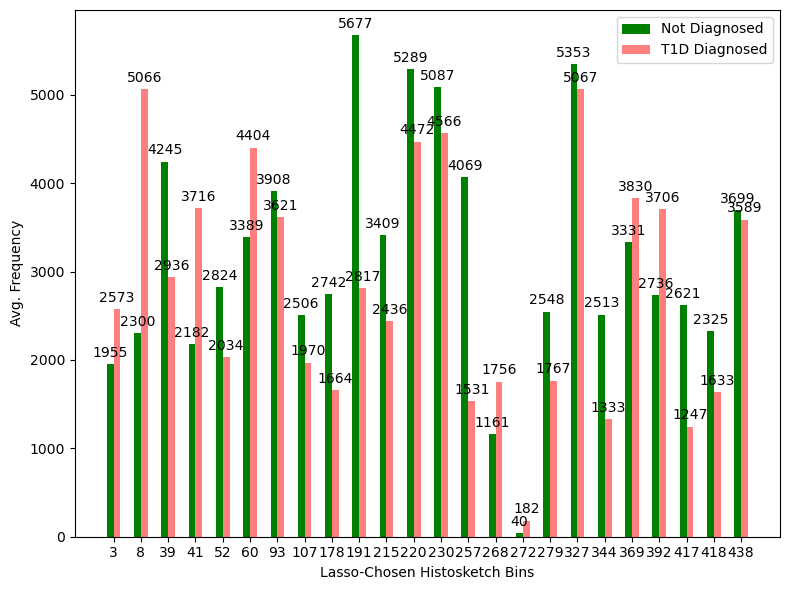

In [168]:
import matplotlib.pyplot as plt

labels = feature_map["Lasso"]
avg_not_diagnosed = np.mean(scaler.inverse_transform(
    X)[y == 0, :][:, feature_map["Lasso"]], axis=0).astype(int)
avg_t1d_diagnosed = np.mean(scaler.inverse_transform(
    X)[y == 1, :][:, feature_map["Lasso"]], axis=0).astype(int)
scale = 100

x_loc = np.arange(len(labels)) * scale
width = scale / 4

fig, ax = plt.subplots(figsize=(8, 6))
rect_not = ax.bar(x_loc - width / 2,
                  avg_not_diagnosed, width, label="Not Diagnosed", alpha=1, color="green")
rect_t1d = ax.bar(x_loc + width / 2,
                  avg_t1d_diagnosed, width, label="T1D Diagnosed", alpha=0.5, color="red")

ax.set_ylabel("Avg. Frequency")
ax.set_xlabel("Lasso-Chosen Histosketch Bins")
ax.set_xticks(x_loc, labels)
ax.legend()

ax.bar_label(rect_not, padding=3)
ax.bar_label(rect_t1d, padding=3)

fig.tight_layout()

plt.show()


### Raw Frequency Distribution

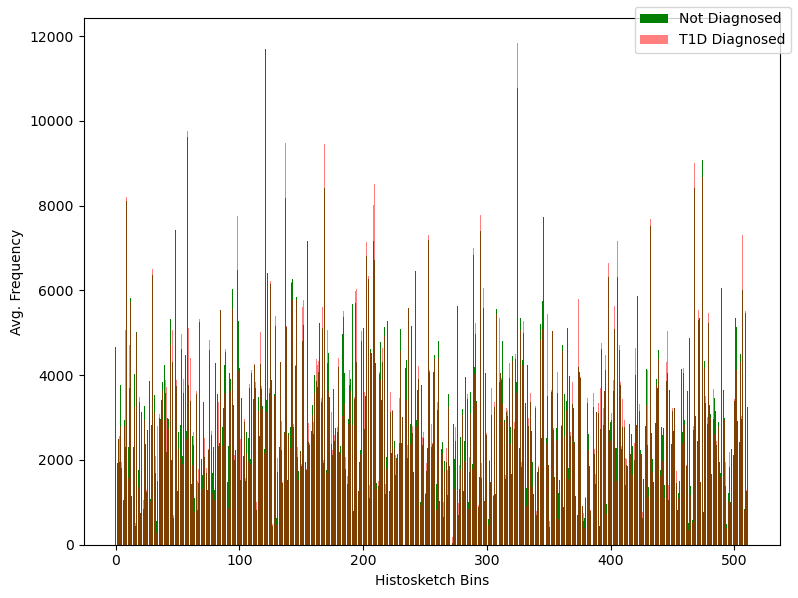

In [164]:
fig, ax = plt.subplots(figsize=(8, 6))
avg_not_diagnosed = np.mean(scaler.inverse_transform(
    X)[y == 0, :][:, feature_map["Regular"]], axis=0)
avg_t1d_diagnosed = np.mean(scaler.inverse_transform(
    X)[y == 1, :][:, feature_map["Regular"]], axis=0)

plt.bar(feature_map["Regular"], avg_not_diagnosed,
        label="Not Diagnosed", alpha=1, color="green")
plt.bar(feature_map["Regular"], avg_t1d_diagnosed,
        label="T1D Diagnosed", alpha=0.5, color="red")

ax.set_ylabel("Avg. Frequency")
ax.set_xlabel("Histosketch Bins")
fig.legend()

fig.tight_layout()

plt.show()
